# 4.3 Final Models: Explanation


In this notebook we try to find explanations for the finalized GCN and GraphSAGE models:

- Feature Density
- GCN/GraphSAGE Model
    - Feature Importance
    - Explanation Subgraphs

### Dataset Configuration

In [25]:
data_name = 'chrome-run-01'
with_centrality_metrics = False

### Set Up

In [26]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import os

In [28]:
import sys
sys.path.append(os.path.join('..', 'models', 'definitions'))
sys.path.append(os.path.join('..', 'src', 'models'))
sys.path.append(os.path.join( '..', 'references'))
import evaluate_model
import tex_config
import pandas as pd

For the evaluation, we load our ```trained``` GNN models and the ```processed``` dataset:

In [29]:
# Load the model and data
org_data_name = data_name
if with_centrality_metrics:
    data_name = f"{data_name}-with-centrality-metrics"
else:
    data_name = f"{data_name}-without-centrality-metrics"

data_path = os.path.join('..', 'data', 'processed', f'{data_name}.pt')
metadata_path = os.path.join('..', 'data', 'processed', f'metadata-{org_data_name}.json')
gcn_path = os.path.join('..', 'models', 'trained', 'gcn.pt')
graphsage_path = os.path.join('..', 'models', 'trained', 'graphsage.pt')
misclassification_gcn = os.path.join('..', 'results', 'gcn', 'misclassifications.csv')
misclassification_graphsage = os.path.join('..', 'results', 'variant', 'misclassifications.csv')

data = torch.load(data_path)
gcn = torch.load(gcn_path)
graphsage = torch.load(graphsage_path)



In [30]:
models = ['gcn', 'variant']
folders = ['explanation_graphs', 'domain_feature_importances']

for model in models:
    for folder in folders:
        path = os.path.join('..', 'results', model, folder)
        if not os.path.exists(path):
            os.makedirs(path)

### Feature Density

In [31]:
# Read csv
csv_file_path = os.path.join('..', 'data', 'raw', f"{org_data_name}.csv")
df = pd.read_csv(csv_file_path, index_col=False)

# Drop unnecessary columns
density_df = df.drop(['Id', 'hostSld', 'Label'], axis=1)

# Other columns to exclude based on the t.ex tex_config
columns_to_exclude = set(tex_config.excluded_features)
density_df = density_df.drop(columns=[col for col in density_df.columns if col.lower() in columns_to_exclude])

# Calculate the density of each column
densities = {}
for col in density_df.columns:
    sparse_col = df[col].astype(pd.SparseDtype('float', 0.0))
    densities[col] = sparse_col.sparse.density

# Create a data frame to store the column densities
density_df = pd.DataFrame(list(densities.items()), columns=['Feature', 'Density'])

# Sort the data frame by density in ascending order
density_df = density_df.sort_values(by='Density')

# Display the density
print('Features With Centrality Metrics:', len(density_df))
print('Density:', density_df['Density'].mean())
density_df


Features With Centrality Metrics: 51
Density: 0.42343902593794636


Feature   Density
10                       media  0.000118
9                       object  0.000276
15                         PUT  0.000395
8                   csp_report  0.000829
7                   main_frame  0.001737
14                        HEAD  0.002368
6                        other  0.010024
45             componentnumber  0.014524
2                         font  0.037572
13                     OPTIONS  0.038164
41        betweenesscentrality  0.058884
4                   stylesheet  0.068237
12                        POST  0.101784
5                    sub_frame  0.115400
19            thirdPartyCookie  0.121438
18                  cookiesSet  0.121438
29  avgCookieFieldsPerNeighbor  0.172784
28        avgCookieFieldsPerRq  0.172784
32               frameIdGtZero  0.189518
0               xmlhttprequest  0.196740
49                  clustering  0.230721
1                        image  0.268924
3                       script  0.287671
43                         Hub  0.322480
40  harmonicclosnesscentrality  0.335938
39          closnesscentrality  0.335938
36                   outdegree  0.335938
38                Eccentricity  0.335938
23            avgQpPerNeighbor  0.366801
22                 avgQpPerReq  0.366801
30           maxSubdomainDepth  0.659957
11                         GET  0.663075
42                   Authority  0.670061
17         firstPartyDisclosed  0.723538
27         avgRespHPerNeighbor  0.731510
26               avgRespHPerRq  0.731510
25            avgRhPerNeighbor  0.731549
31               avgPathLength  0.731549
24                  avgRhPerRq  0.731549
21           avgReqPerNeighbor  0.731549
20                avgUrlLength  0.731549
16                       count  0.731549
35                    indegree  0.731549
50             eigencentrality  0.731549
47            modularity_class  0.953982
33                   sldLength  0.998579
48              stat_inf_class  0.998658
46               strongcompnum  0.999961
37                      degree  1.000000
34               hostUrlLength  1.000000
44                   pageranks  1.000000

### GCN Model

#### Feature Importance

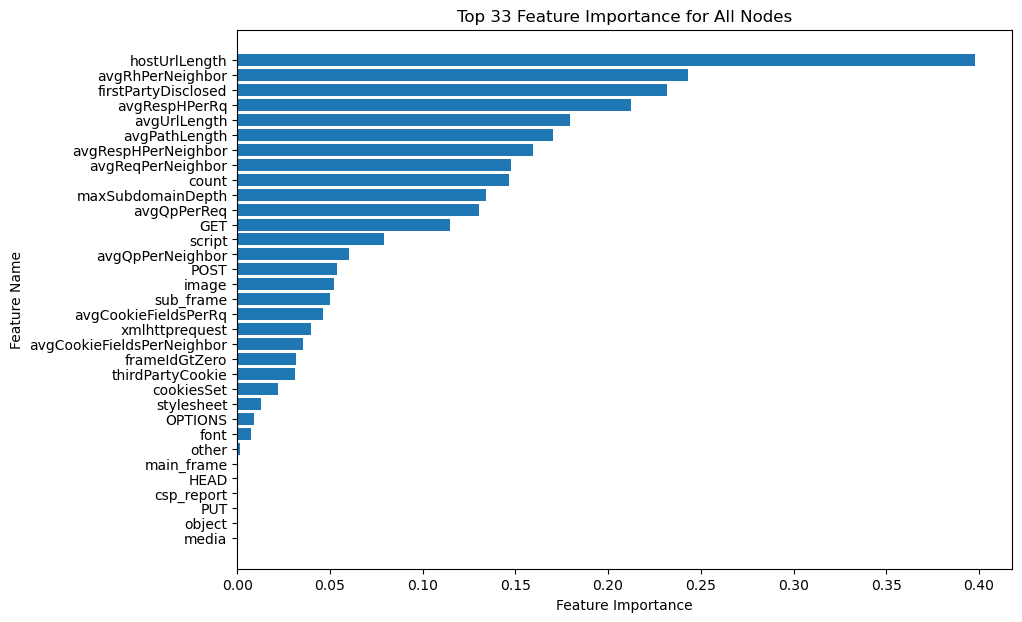

In [32]:
figs = evaluate_model.plot_feature_importance(metadata_path, gcn, data)

for fig, domain_name in figs:
    fig.savefig(os.path.join('..', 'results', 'gcn', 'feature_importance'))

#### Explanation Subgraphs

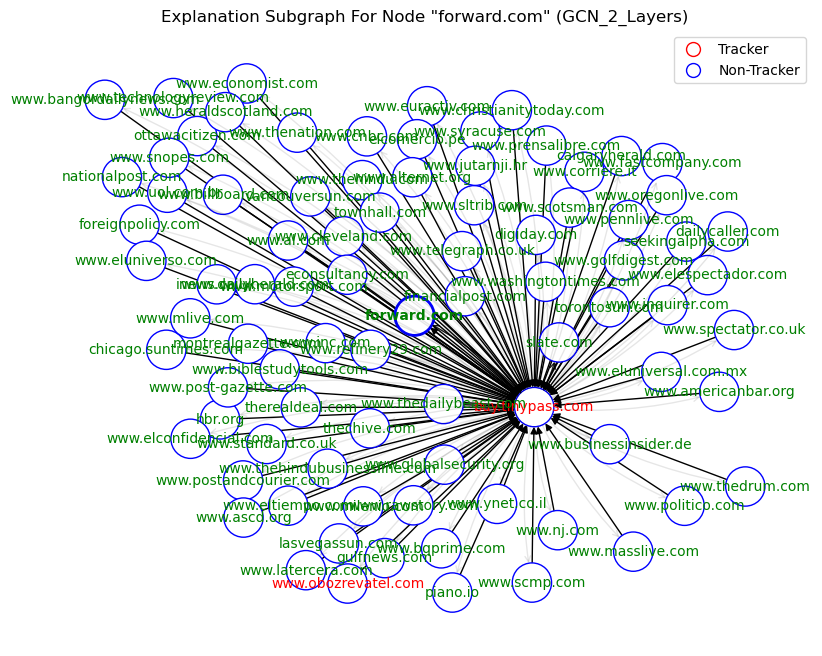

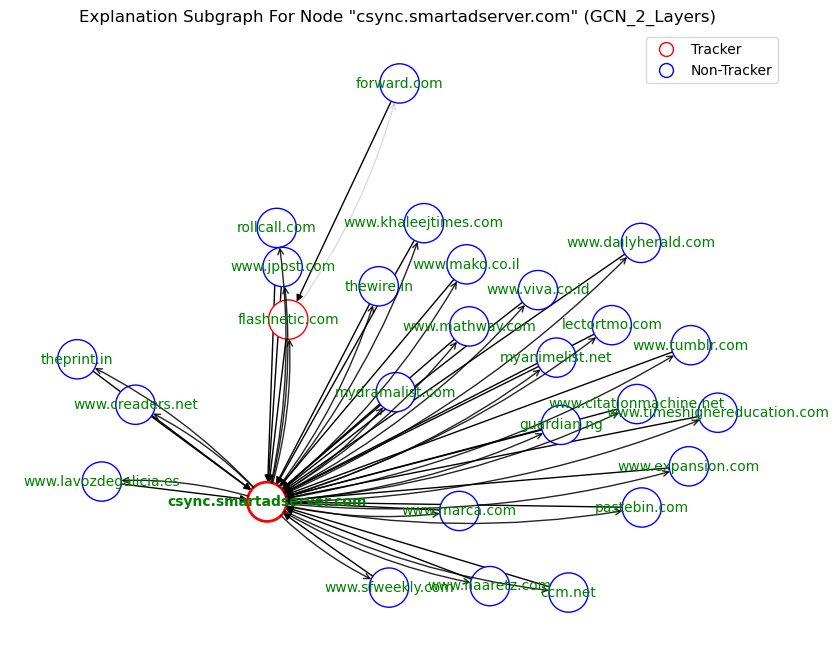

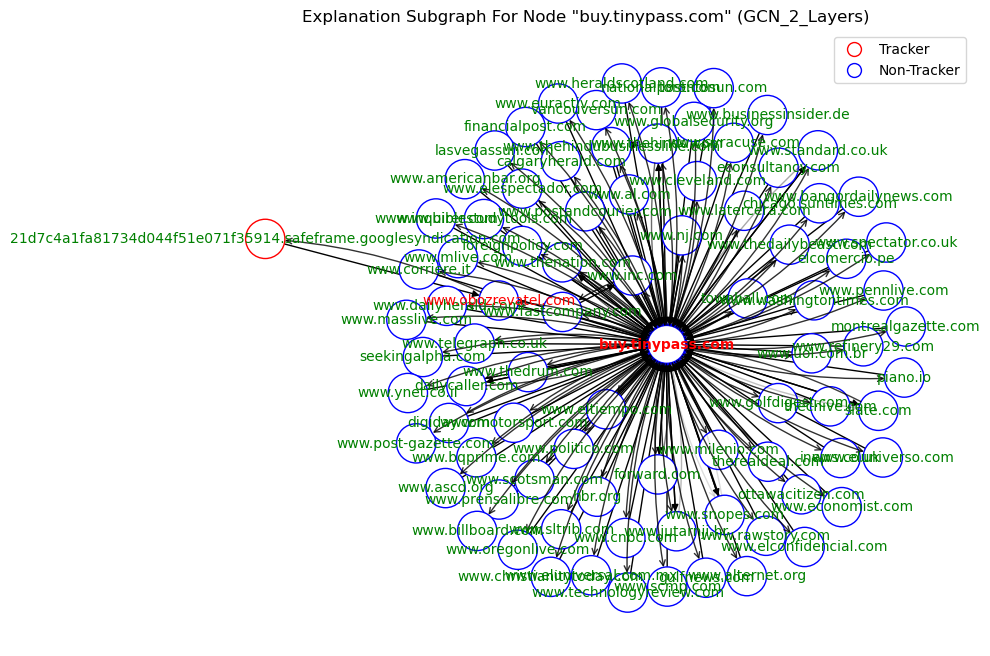

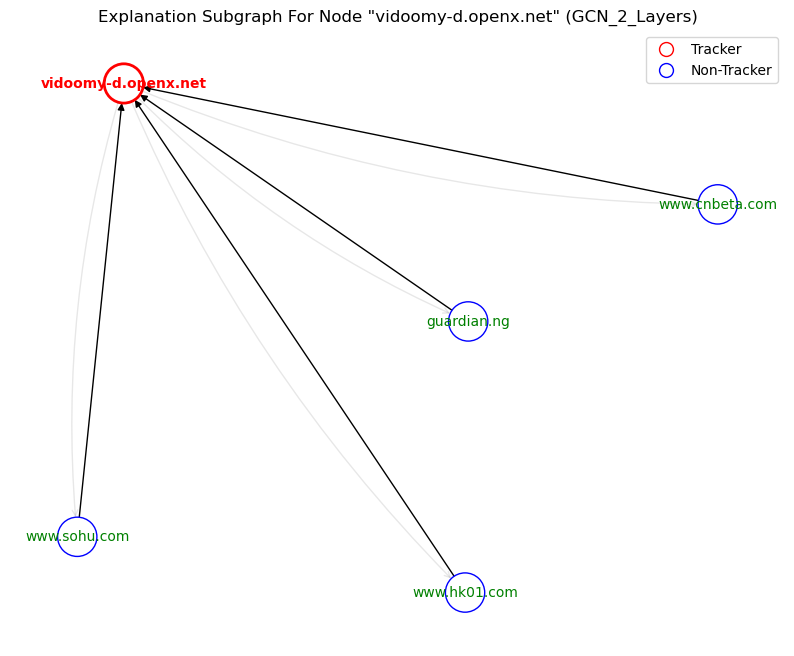

In [33]:
figs = evaluate_model.plot_explain_subgraphs(gcn, data, ["forward.com", "csync.smartadserver.com", "buy.tinypass.com", "vidoomy-d.openx.net"], metadata_path, misclassification_gcn)

for fig, domain_name in figs:
    fig.savefig(os.path.join('..', 'results', 'gcn', 'explanation_graphs', f"{domain_name}.png"))

### GraphSAGE Model

#### Feature Importance

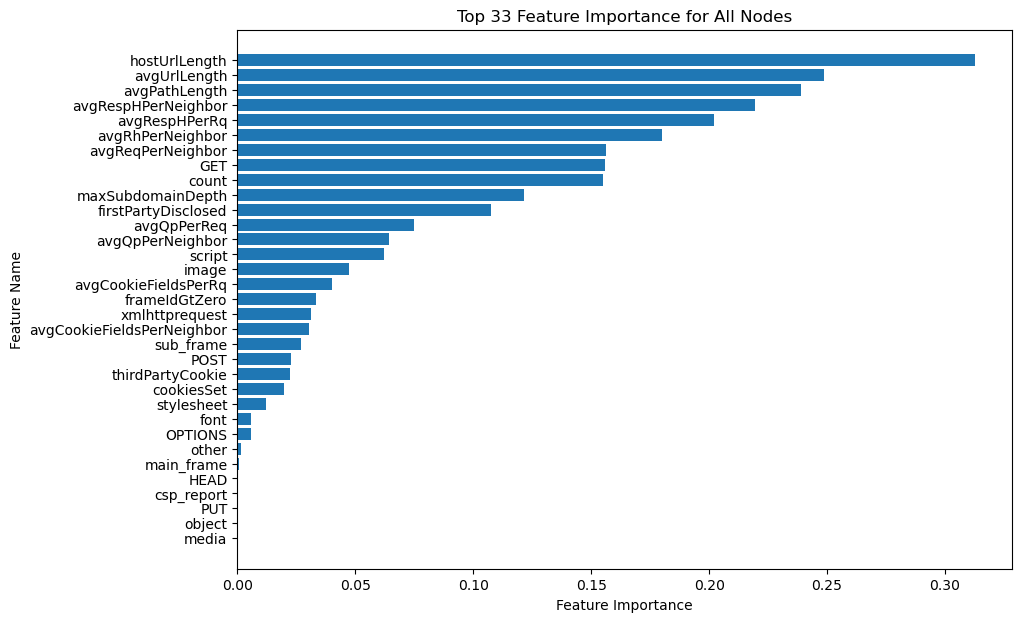

In [34]:
figs = evaluate_model.plot_feature_importance(metadata_path, graphsage, data)

for fig, domain_name in figs:
    fig.savefig(os.path.join('..', 'results', 'variant', 'feature_importance'))

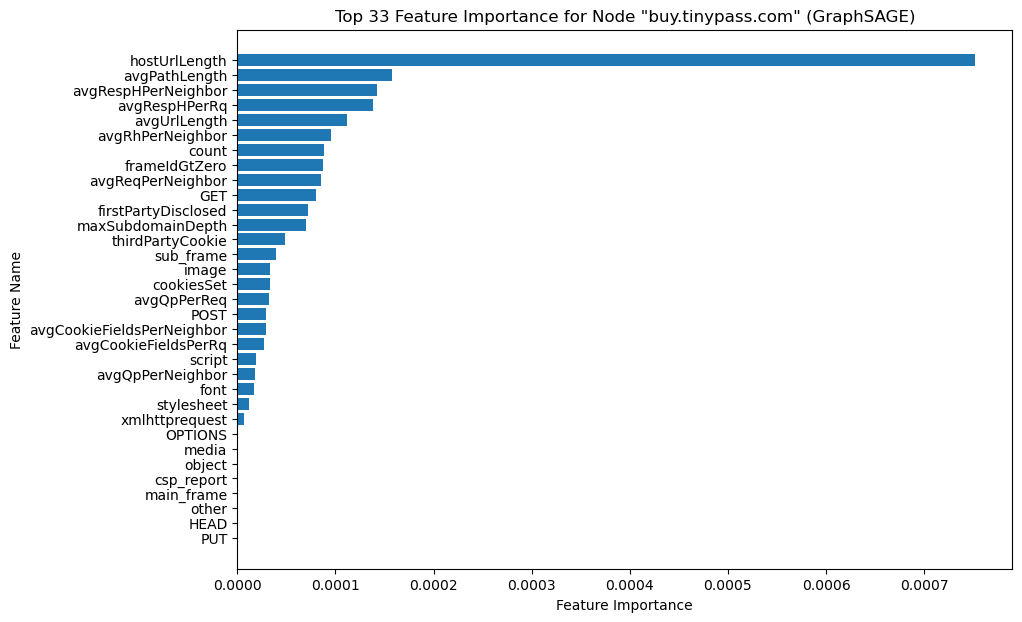

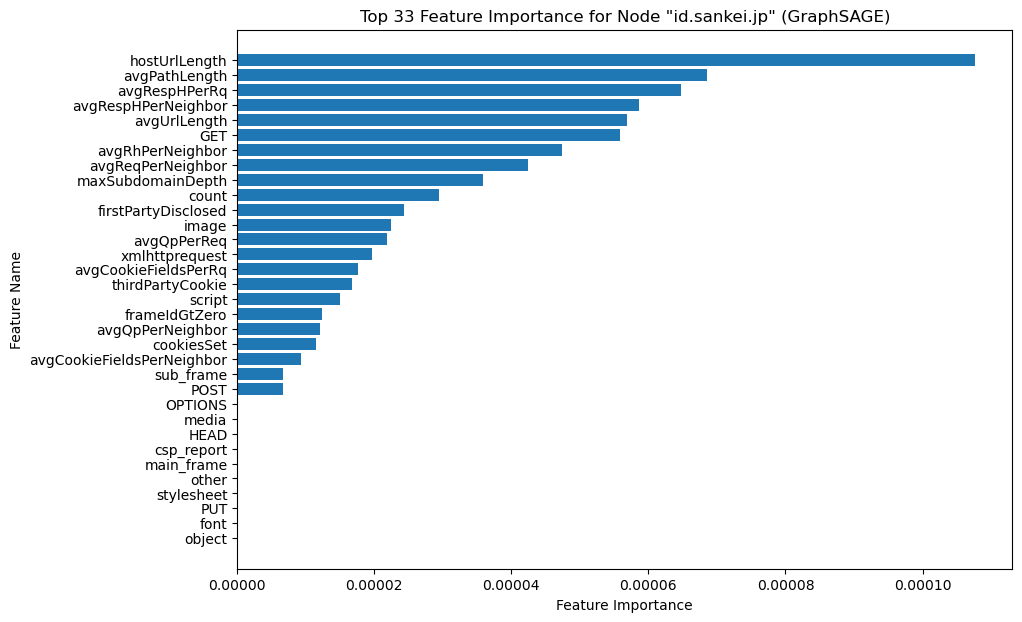

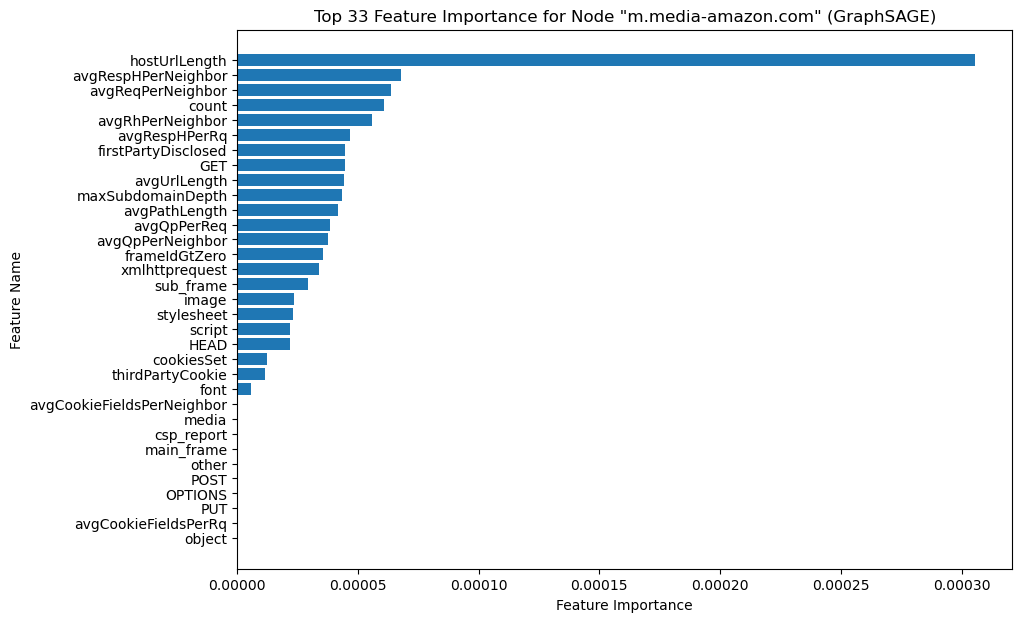

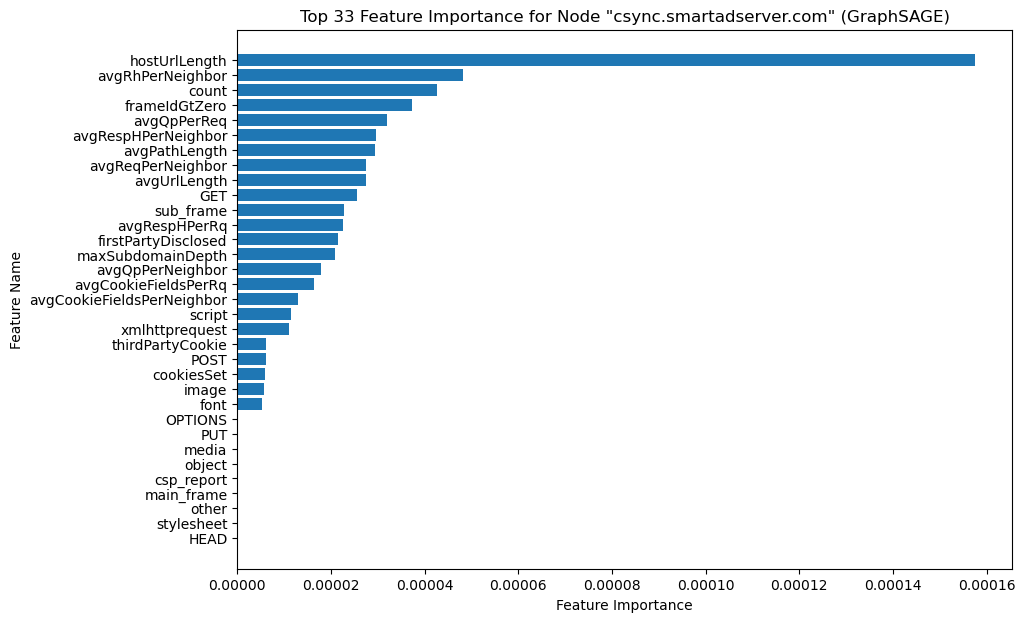

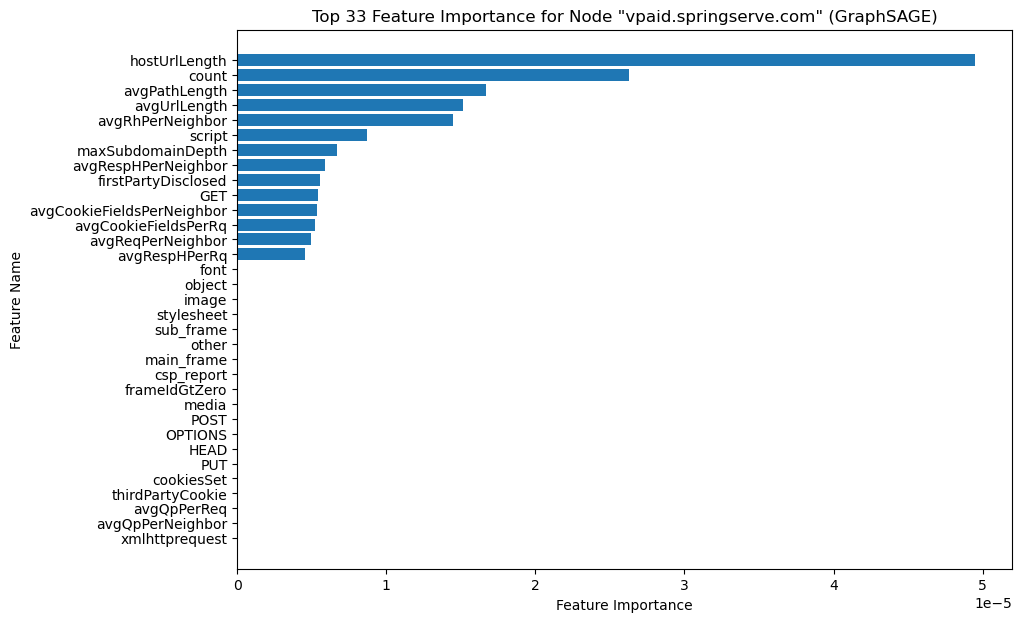

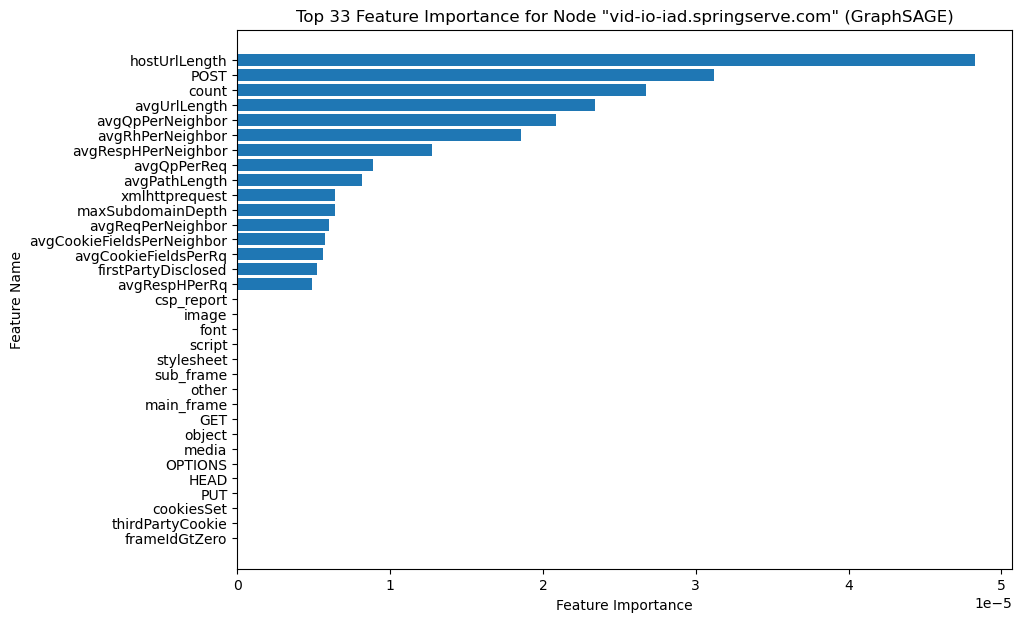

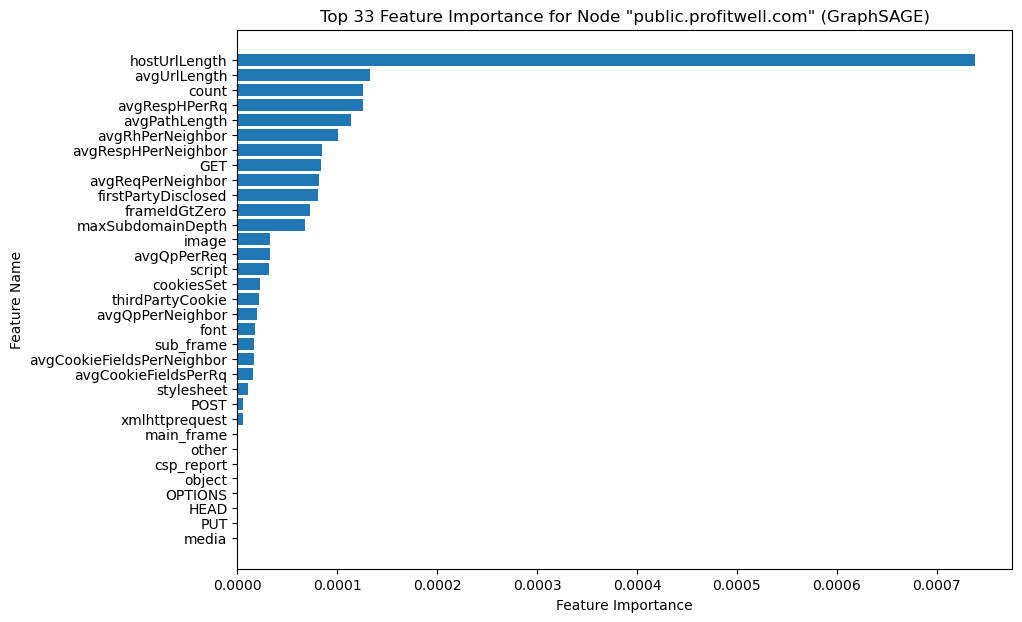

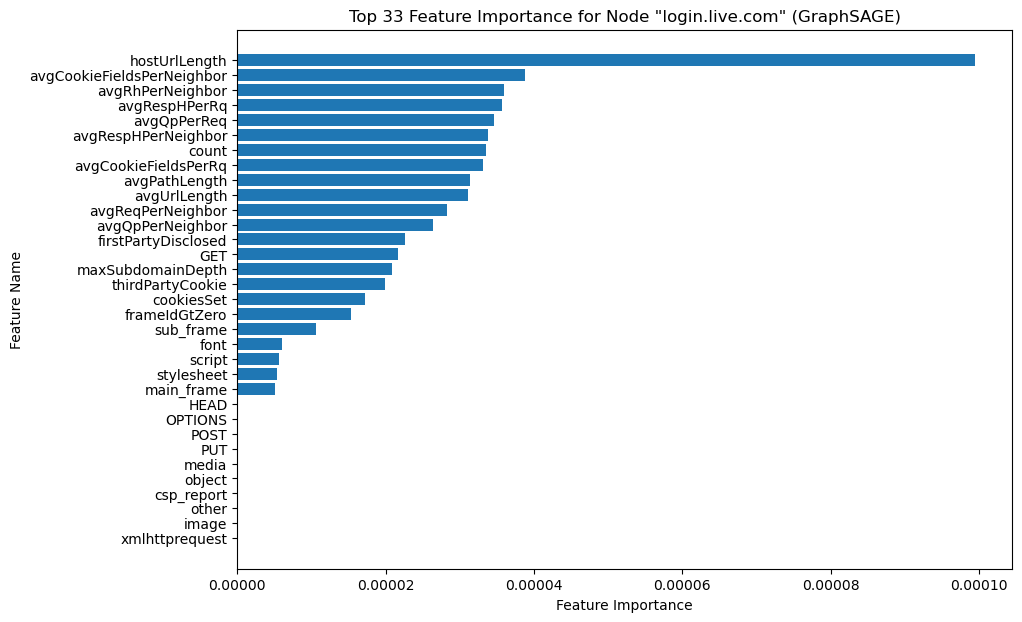

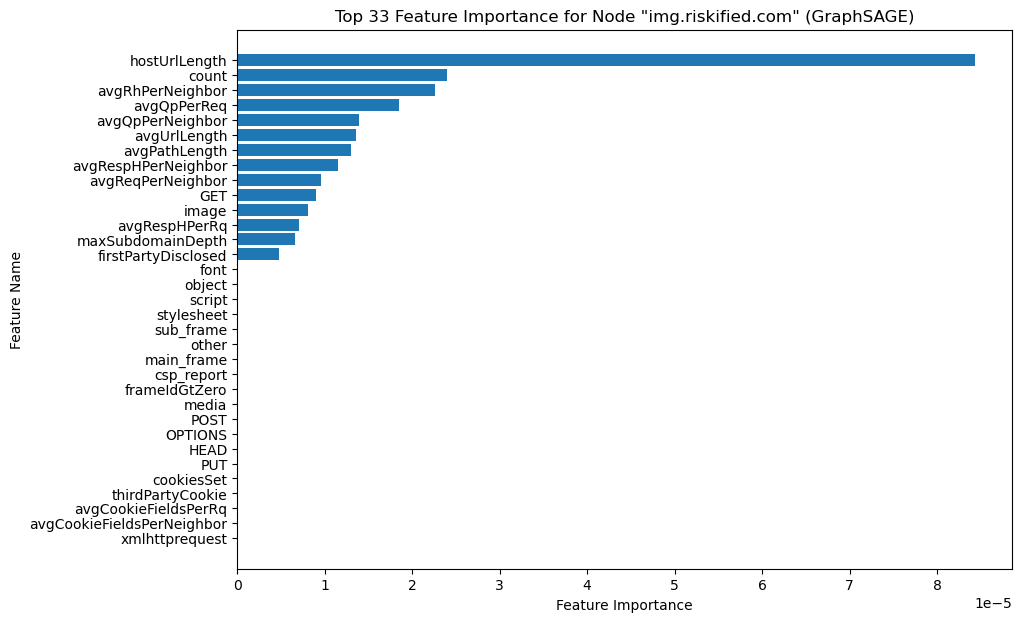

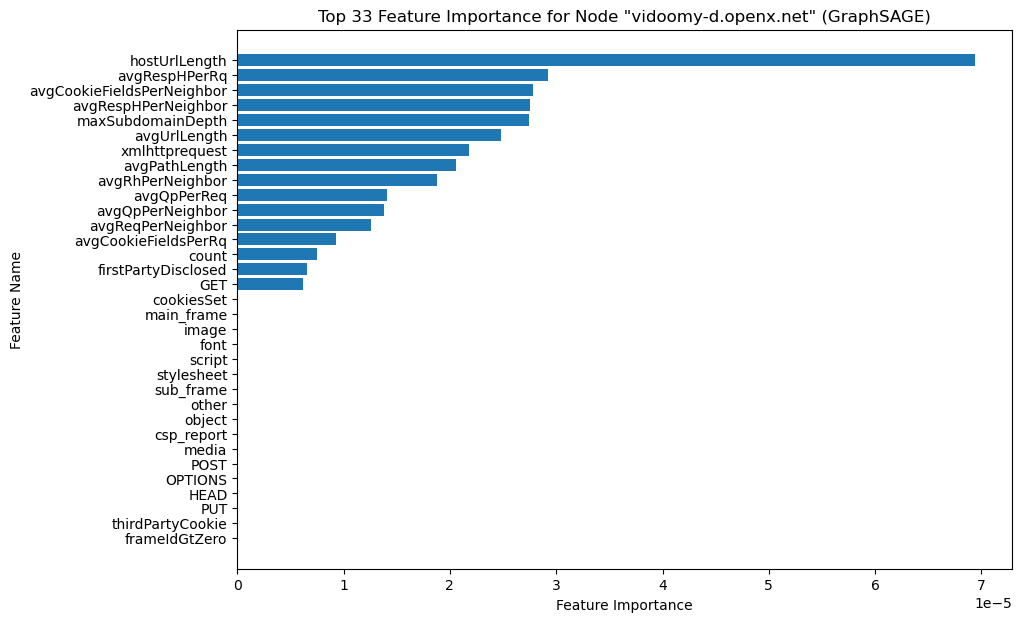

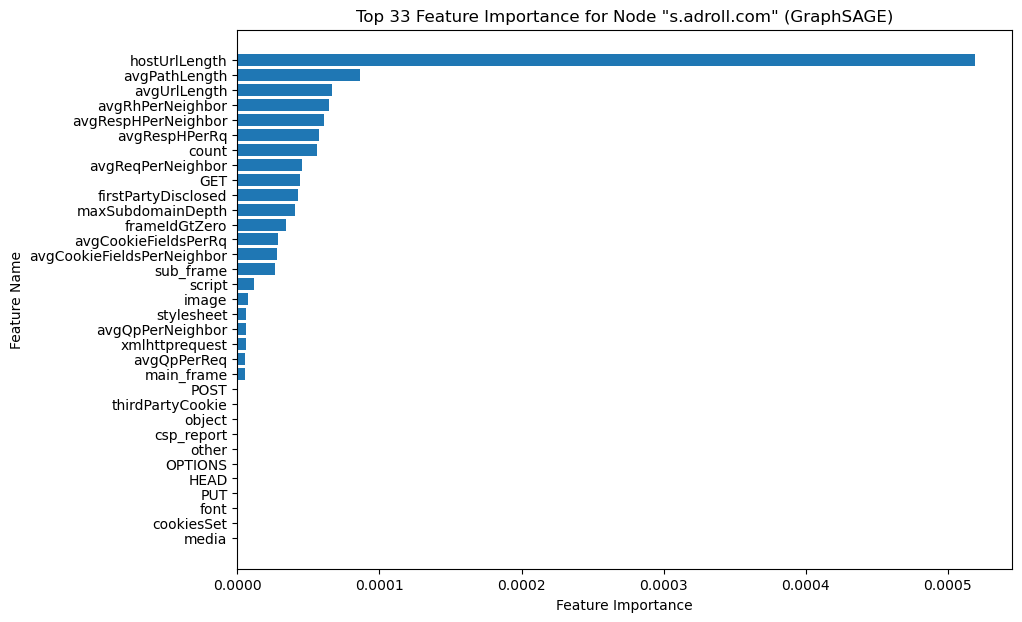

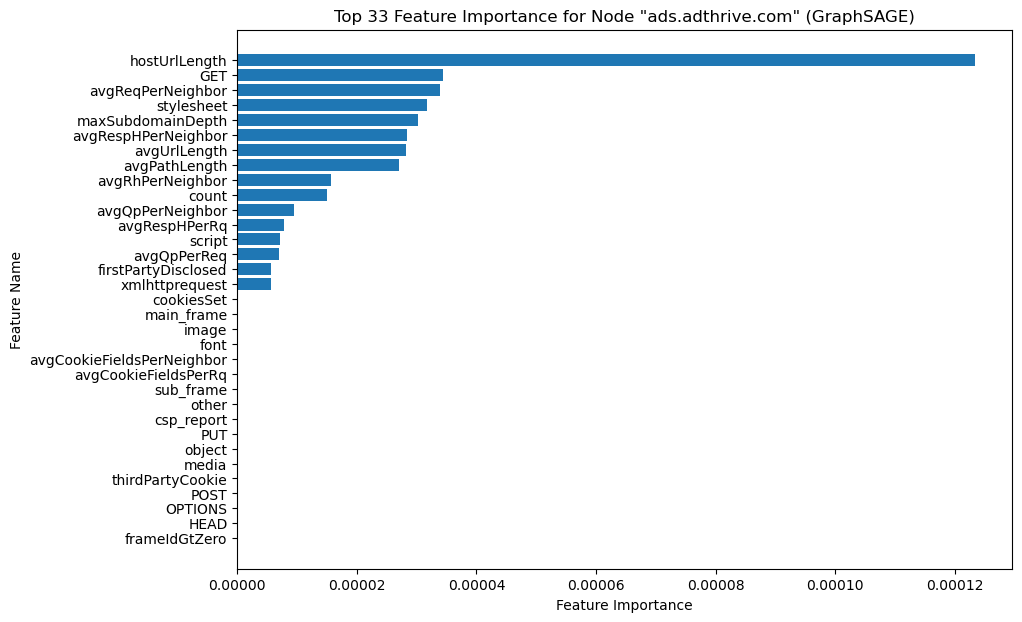

In [35]:
domain_names = ["buy.tinypass.com", "id.sankei.jp", "m.media-amazon.com", "csync.smartadserver.com", "vpaid.springserve.com", "vid-io-iad.springserve.com",  "public.profitwell.com", "login.live.com", "img.riskified.com", "vidoomy-d.openx.net", "s.adroll.com", "ads.adthrive.com"]

figs = evaluate_model.plot_feature_importance(metadata_path, graphsage, data, domain_names=domain_names)

for fig, domain_name in figs:
    fig.savefig(os.path.join('..', 'results', 'variant', 'domain_feature_importances', f"{domain_name}.png"))

#### Explanation Subgraphs

Non-Trackers that were correctly classified:

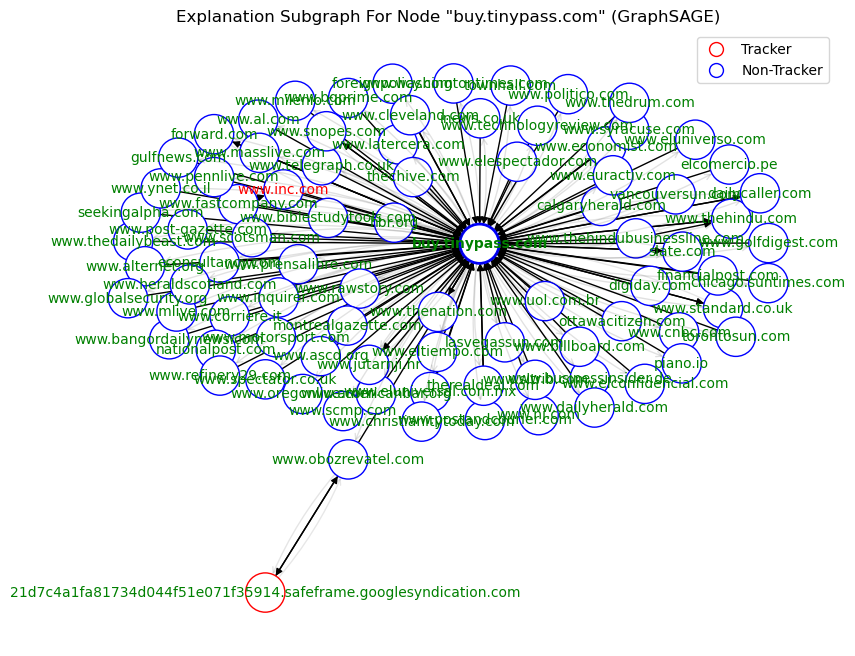

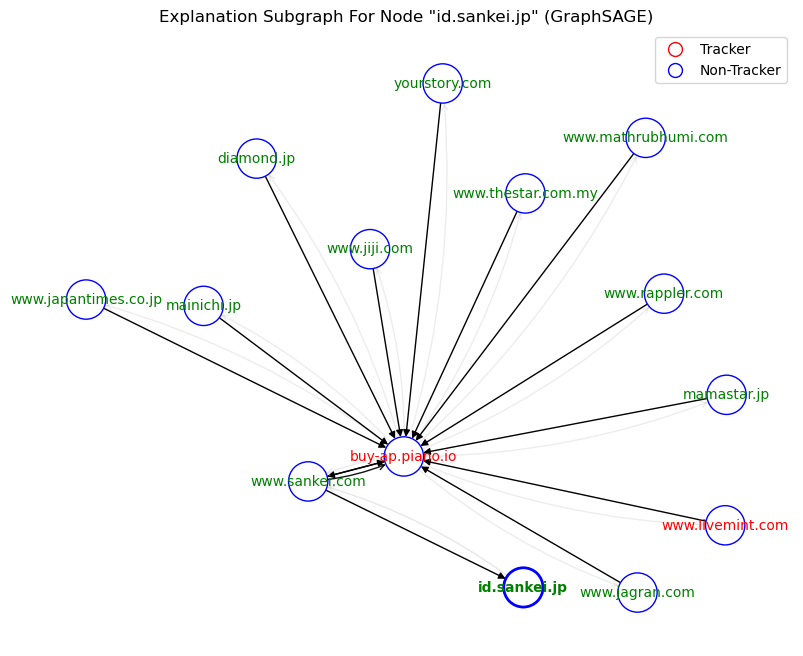

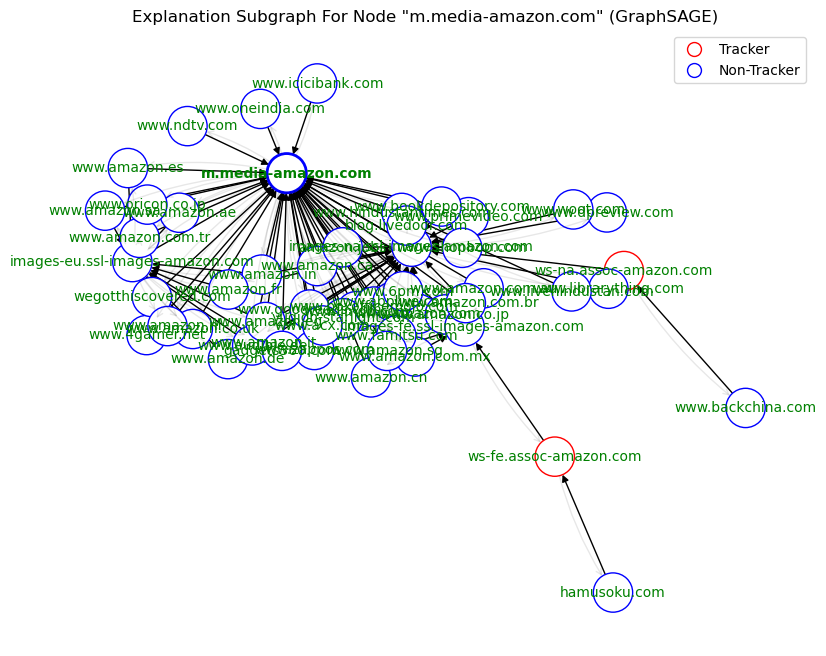

In [36]:
figs = evaluate_model.plot_explain_subgraphs(graphsage, data, ["buy.tinypass.com", "id.sankei.jp", "m.media-amazon.com"], metadata_path, misclassification_graphsage)


Trackers that were correctly classified:

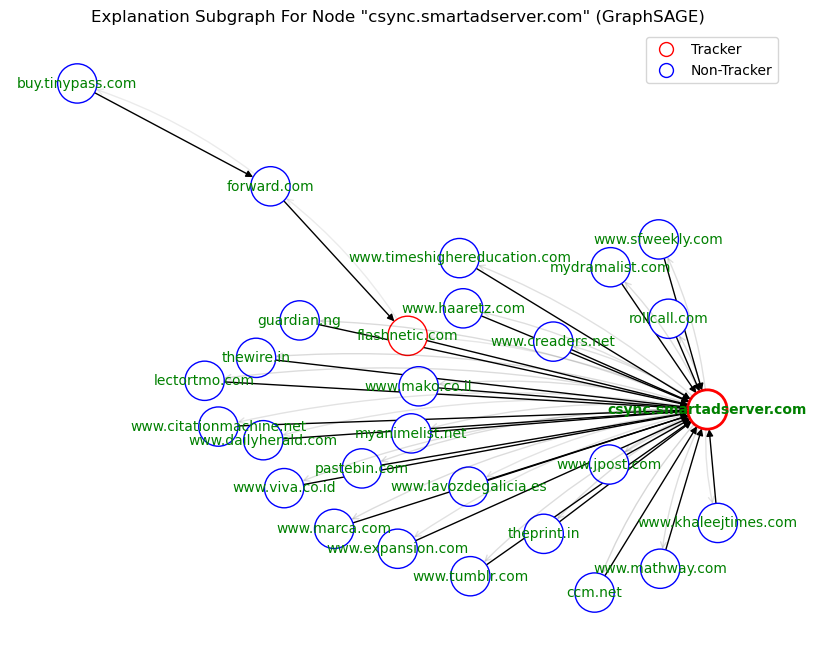

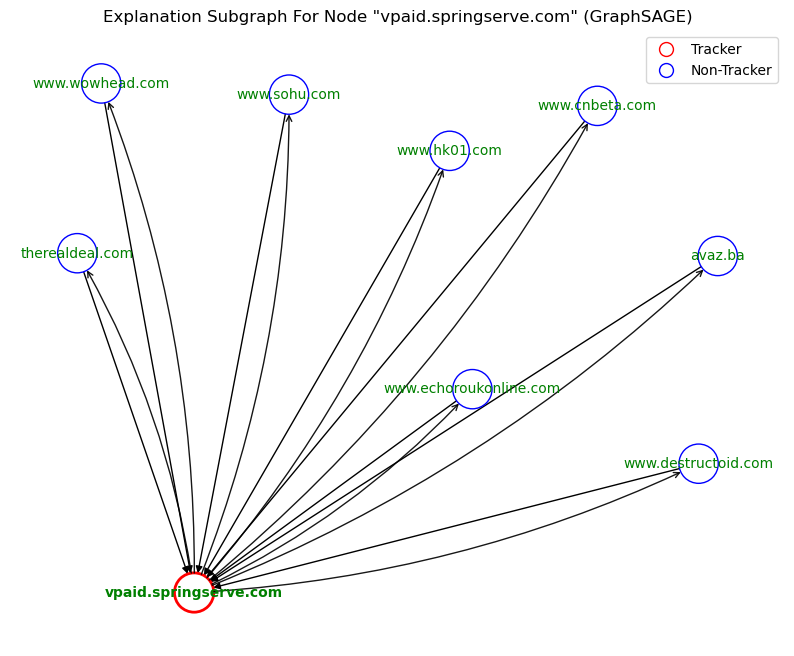

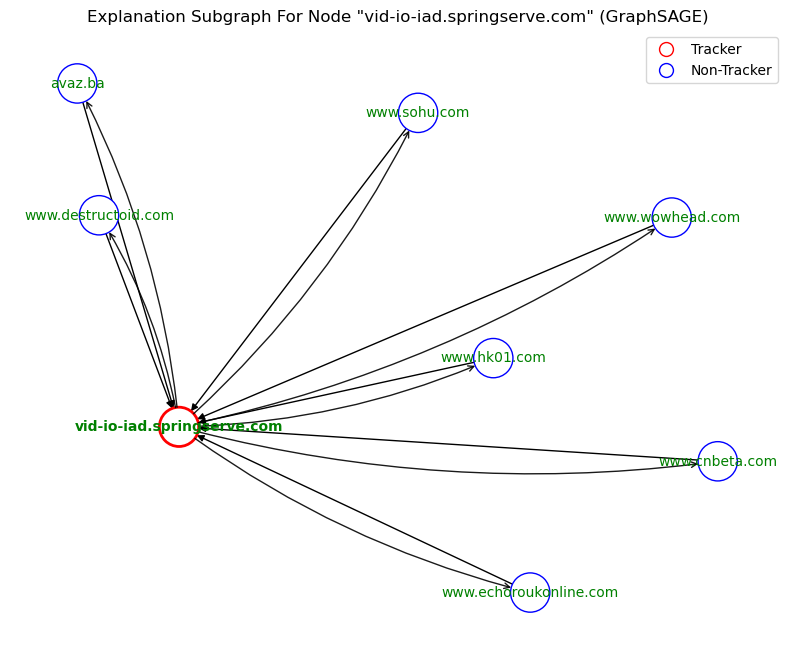

In [37]:
figs.extend(evaluate_model.plot_explain_subgraphs(graphsage, data, ["csync.smartadserver.com", "vpaid.springserve.com", "vid-io-iad.springserve.com"], metadata_path, misclassification_graphsage)) 


Non-Trackers that were misclassified:

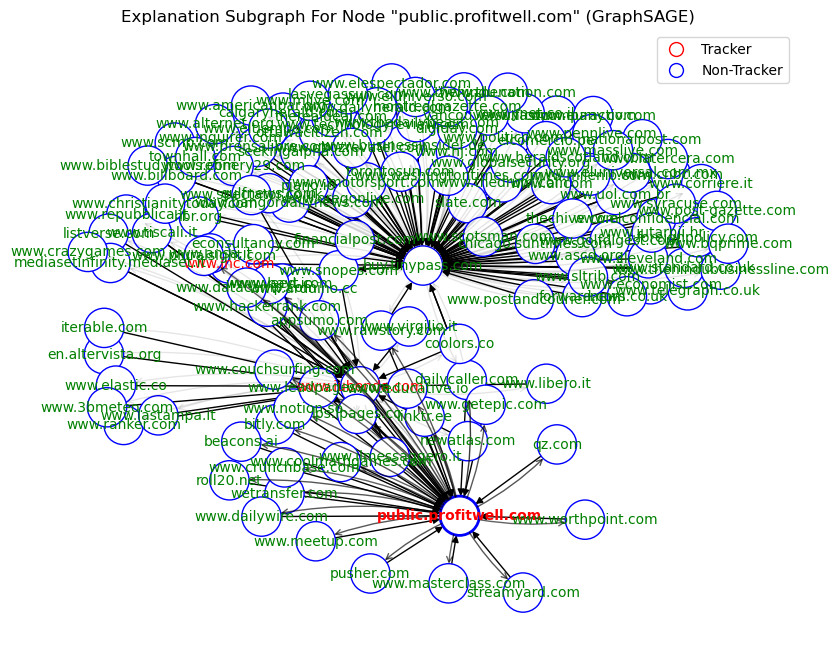

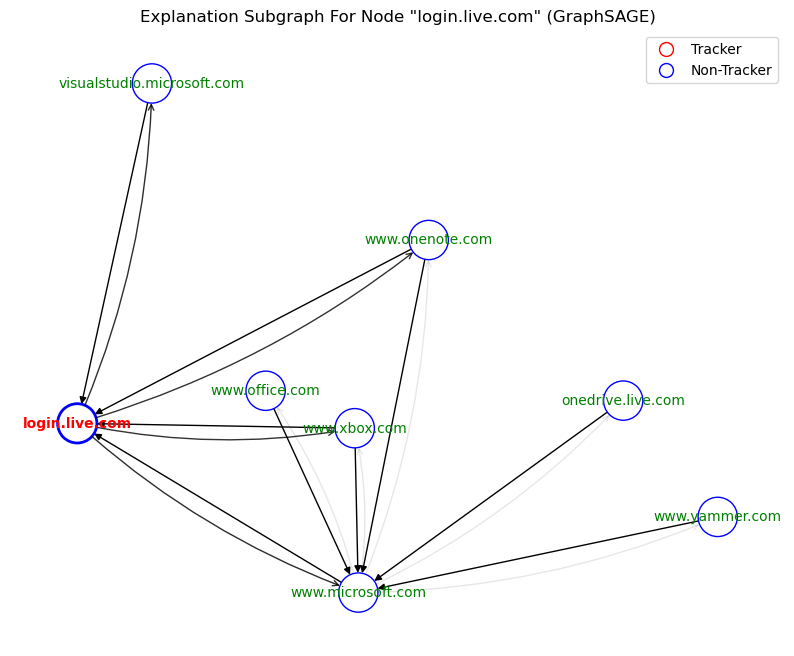

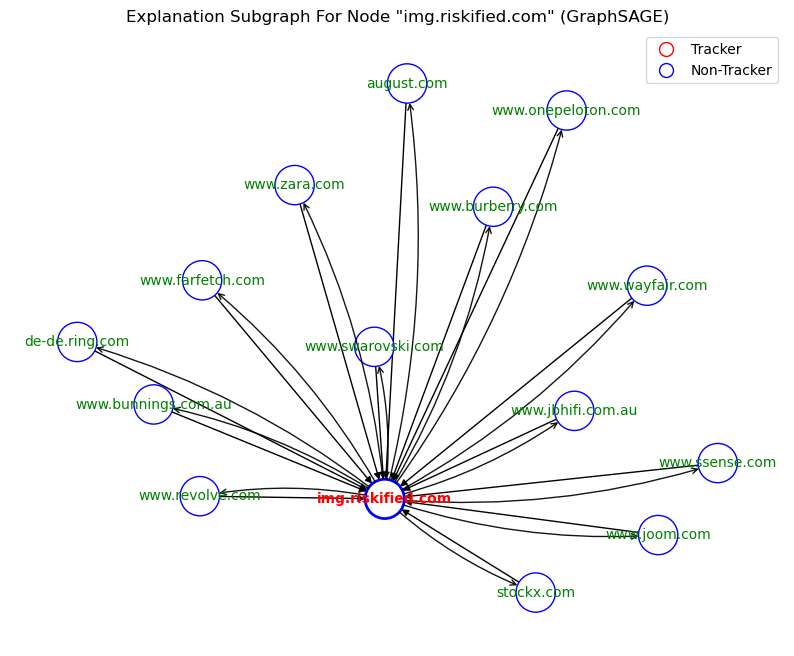

In [38]:
figs.extend(evaluate_model.plot_explain_subgraphs(graphsage, data, ["public.profitwell.com", "login.live.com", "img.riskified.com"], metadata_path, misclassification_graphsage))


Trackers that were misclassified:

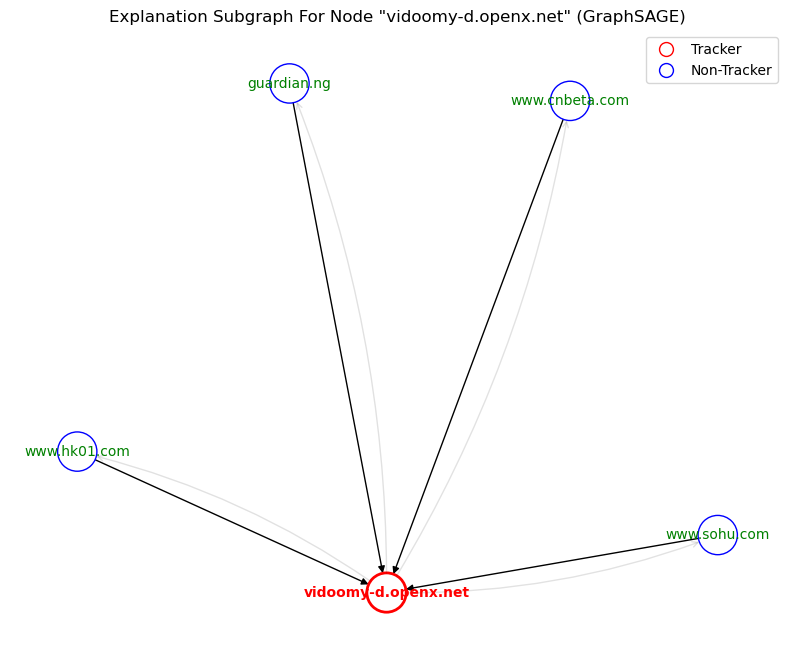

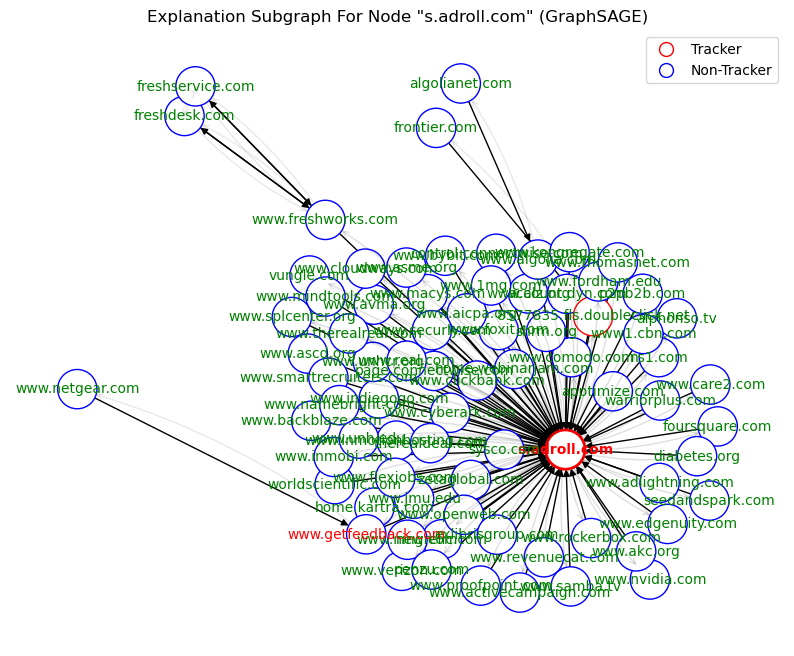

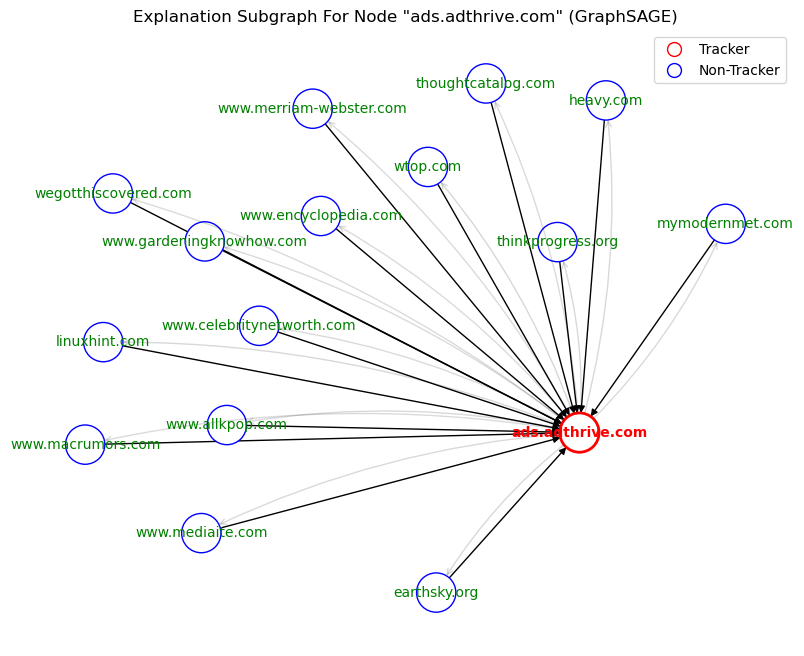

In [39]:
figs.extend(evaluate_model.plot_explain_subgraphs(graphsage, data, ["vidoomy-d.openx.net", "s.adroll.com", "ads.adthrive.com"], metadata_path, misclassification_graphsage))

for fig, domain_name in figs:
    fig.savefig(os.path.join('..', 'results', 'variant', 'explanation_graphs', f"{domain_name}.png"))